###  SOLUBILITY

In [1]:
!pip install scikit-learn-intelex

   ---------------------------------------- 0.0/8.5 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.5 MB 7.4 MB/s eta 0:00:01
   -------------------- ------------------- 4.5/8.5 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------- 8.5/8.5 MB 14.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/46.7 MB ? eta -:--:--
   ---- ----------------------------------- 4.7/46.7 MB 22.0 MB/s eta 0:00:02
   -------- ------------------------------- 9.4/46.7 MB 22.6 MB/s eta 0:00:02
   ----------- ---------------------------- 13.4/46.7 MB 20.5 MB/s eta 0:00:02
   --------------- ------------------------ 18.4/46.7 MB 21.5 MB/s eta 0:00:02
   ------------------ --------------------- 21.5/46.7 MB 20.3 MB/s eta 0:00:02
   -------------------- ------------------- 23.9/46.7 MB 18.9 MB/s eta 0:00:02
   ------------------------ --------------- 28.6/46.7 MB 18.9 MB/s eta 0:00:01
   --------------------------- ------------ 32.5/46.7 MB 18.8 MB/s eta 0:00:01
 

### USING INTEL EXTENSION FOR SCIKIT LEARN

In [22]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [23]:
from time import time

In [24]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from rdkit import Chem
from rdkit.Chem import AllChem
from tdc.single_pred.adme import ADME
from tdc import Evaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Featurizer class definition
class Featurizer:
    def __init__(self, y_column, smiles_col='Drug', **kwargs):
        self.y_column = y_column
        self.smiles_col = smiles_col
        self.__dict__.update(kwargs)

    def __call__(self, df):
        raise NotImplementedError()

# ECFP Featurizer for molecular fingerprint generation
class ECFPFeaturizer(Featurizer):
    def __init__(self, y_column, radius=2, length=1024, **kwargs):
        self.radius = radius
        self.length = length
        super().__init__(y_column, **kwargs)

    def __call__(self, df):
        fingerprints = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)
            fingerprints.append(fp)
            labels.append(y)
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels


In [25]:
# Load data
data = ADME('Solubility_AqSolDB')

Found local copy...
Loading...
Done!


In [26]:
split = data.get_split()

# Featurize data
featurizer = ECFPFeaturizer(y_column='Y')
X_train, y_train = featurizer(split['train'])
X_valid, y_valid = featurizer(split['valid'])
X_test, y_test = featurizer(split['test'])


[16:24:41] WARNING: not removing hydrogen atom without neighbors
[16:24:41] WARNING: not removing hydrogen atom without neighbors
[16:24:41] WARNING: not removing hydrogen atom without neighbors
[16:24:42] WARNING: not removing hydrogen atom without neighbors
[16:24:42] WARNING: not removing hydrogen atom without neighbors
[16:24:42] WARNING: not removing hydrogen atom without neighbors
[16:24:42] WARNING: not removing hydrogen atom without neighbors
[16:24:42] WARNING: not removing hydrogen atom without neighbors
[16:24:42] WARNING: not removing hydrogen atom without neighbors
[16:24:42] WARNING: not removing hydrogen atom without neighbors
[16:24:42] WARNING: not removing hydrogen atom without neighbors
[16:24:42] WARNING: not removing hydrogen atom without neighbors
[16:24:42] WARNING: not removing hydrogen atom without neighbors
[16:24:42] WARNING: not removing hydrogen atom without neighbors
[16:24:42] WARNING: not removing hydrogen atom without neighbors
[16:24:42] WARNING: not r

In [27]:
train_df = pd.DataFrame(split['train'])
valid_df = pd.DataFrame(split['valid'])
test_df = pd.DataFrame(split['test'])

In [28]:
train_df

,Drug_ID,Drug,Y
0,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
1,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
2,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
3,vinyltoluene,C=Cc1cccc(C)c1,-3.123150
4,3-(3-ethylcyclopentyl)propanoic acid,CCC1CCC(CCC(=O)O)C1,-3.286116
...,...,...,...
6983,sarafloxacin,O=C(O)c1cn(-c2ccc(F)cc2)c2cc(N3CCNCC3)c(F)cc2c1=O,-3.130000
6984,sparfloxacin,C[C@H]1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c...,-3.370000
6985,sulindac_form_II,CC1=C(CC(=O)O)c2cc(F)ccc2/C1=C/c1ccc(S(C)=O)cc1,-4.500000
6986,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000


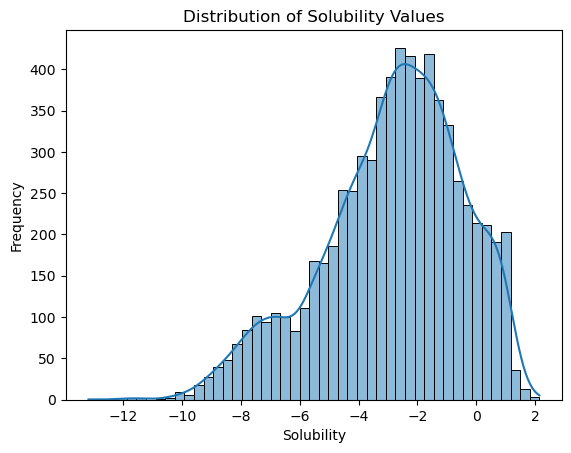

In [29]:
sns.histplot(train_df['Y'], kde=True)
plt.title('Distribution of Solubility Values')
plt.xlabel('Solubility')
plt.ylabel('Frequency')
plt.show()

In [30]:
print(train_df.describe())

                 Y
count  6988.000000
mean     -2.862946
std       2.387322
min     -13.171900
25%      -4.280085
50%      -2.591850
75%      -1.155815
max       2.137682


In [31]:
def train(X_train, y_train, X_valid, y_valid):
    params = {"n_estimators": 150, "random_state": 44, "n_jobs": -1}
    
    start = time()  
    
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    
    train_time = time() - start
    
    valid_predictions = model.predict(X_valid)
    
    valid_rmse = mean_squared_error(y_valid, valid_predictions, squared=False)
    valid_mae = mean_absolute_error(y_valid, valid_predictions)
    valid_r2 = r2_score(y_valid, valid_predictions)
    
    print(f'Validation RMSE: {valid_rmse}, MAE: {valid_mae}, R2: {valid_r2}')
    print(f"Intel® extension for Scikit-learn time: {train_time:.2f} s")
    
    return model

In [32]:
def predict(model, X_test):
    predictions = model.predict(X_test)
    return predictions


In [33]:
# Train model
model = train(X_train, y_train, X_valid, y_valid)

# Make predictions on the test set
predictions = predict(model, X_test)

# Evaluate predictions
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'RMSE: {rmse}, MAE: {mae}, R2: {r2}')


Validation RMSE: 1.404638773161333, MAE: 1.005122259160314, R2: 0.6282097685576374
Intel® extension for Scikit-learn time: 44.76 s
RMSE: 1.3445198796483075, MAE: 0.9833048091400252, R2: 0.6668808816239422


### WITHOUT USING INTEL ONEAPI EXTENSION FOR SCIKIT LEARN

In [34]:
from sklearnex import unpatch_sklearn

unpatch_sklearn()

In [42]:
def train(X_train, y_train, X_valid, y_valid):
    params = {"n_estimators": 150, "random_state": 44, "n_jobs": -1}
    
    start = time()  
    
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    
    train_time = time() - start 
    
    valid_predictions = model.predict(X_valid)
    
    valid_rmse = mean_squared_error(y_valid, valid_predictions, squared=False)
    valid_mae = mean_absolute_error(y_valid, valid_predictions)
    valid_r2 = r2_score(y_valid, valid_predictions)
    
    print(f'Validation RMSE: {valid_rmse}, MAE: {valid_mae}, R2: {valid_r2}')
    print(f"Without Intel® extension for Scikit-learn time: {train_time:.2f} s")
    
    return model

In [41]:
model = train(X_train, y_train, X_valid, y_valid)

# Make predictions on the test set
predictions = predict(model, X_test)

# Evaluate predictions
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'RMSE: {rmse}, MAE: {mae}, R2: {r2}')

Validation RMSE: 1.404638773161333, MAE: 1.005122259160314, R2: 0.6282097685576374
Without Intel® extension for Scikit-learn time: 78.94 s
RMSE: 1.3445198796483075, MAE: 0.9833048091400252, R2: 0.6668808816239422


### SAVING THE MODEL

In [43]:
# Save the trained model as a pickle file
with open('solubility_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved as solubility_model.pkl")


Model saved as solubility_model.pkl


In [44]:
class Pre_Featurizer:
    def __init__(self, y_column, smiles_col='Drug', **kwargs):
        self.y_column = y_column
        self.smiles_col = smiles_col
        self.__dict__.update(kwargs)

    def __call__(self, df):
        raise NotImplementedError()

# ECFP Featurizer for molecular fingerprint generation
class Pre_ECFPFeaturizer(Pre_Featurizer):
    def __init__(self, y_column=None, radius=2, length=1024, **kwargs):
        self.radius = radius
        self.length = length
        super().__init__(y_column, **kwargs)

    def __call__(self, df):
        fingerprints = []
        labels = []
        for i, row in df.iterrows():
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)
            fingerprints.append(fp)

            # Only append labels if y_column is present in the dataframe
            if self.y_column and self.y_column in df.columns:
                labels.append(row[self.y_column])

        fingerprints = np.array(fingerprints)
        labels = np.array(labels) if labels else None
        return fingerprints, labels

In [69]:
# Load the model from pickle file
with open('solubility_model.pkl', 'rb') as f:
    model = pickle.load(f)

def predict_single_smiles(smiles, model, featurizer):
    # Create a dataframe for the single SMILES string (since the featurizer expects a dataframe)
    df = pd.DataFrame({featurizer.smiles_col: [smiles]})

    # Featurize the SMILES string
    X_new, _ = featurizer(df)  # We don't need the labels here, so they can be ignored

    # Make prediction (for regression, no need for predict_proba)
    prediction_value = model.predict(X_new)[0]  # Predicted solubility value

    return prediction_value

# Initialize the same featurizer as used during training
featurizer = Pre_ECFPFeaturizer()  # No need to pass y_column for prediction
smiles_string = "CCCCCC1=CC2=C(C3C=C(CCC3C(O2)(C)C)C)C(=C1)O"  #  CC(C)CC1=CC=C(C=C1)C(C)C(=O)O     

# Make predictions for the single SMILES string
predicted_value = predict_single_smiles(smiles_string, model, featurizer)

print(f'Predicted Solubility Value: {predicted_value}')



Predicted Solubility Value: -4.385753905076
